# Example 1 : Looking at a MUSIC ROOT data file using uproot

First we will load in the the primary python tools we will be using, pandas, numpy and matplotlib. To make the plots a little nicer in Jupyter we will change some params too.

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 200 # bigger figures

# Use more REVTEX-esque fonts?
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "STIXGeneral"
mpl.rcParams["mathtext.fontset"] = "stix"

In this directory you should see a ROOT file "test_music_data.root" which has some data from an experiment which had a $^{20}$Ne beam on methane gas inside of MUSIC. Lets import uproot and take a look at the data.

In [5]:
import uproot

To open the file we use the open function in uproot.

In [8]:
file = uproot.open("test_music_data.root")

print(type(file))

<class 'uproot.reading.ReadOnlyDirectory'>


We can extract the keys just like any python dictionary.

In [9]:
file.keys()

['tree;2', 'tree;1']

Or we can get the classes.

In [11]:
file.classnames()

{'tree;2': 'TTree', 'tree;1': 'TTree'}

Let's now create an object to access the first tree and look at the keys within the tree structure.

In [12]:
tree = file['tree;1']

tree.keys()

['edepl',
 'edepr',
 'seg',
 'regl',
 'regr',
 'cath',
 'grid',
 'strip0',
 'strip17',
 'tac']

Now we can see some structure which is closer to the things we think of with MUSIC (strip0, cath for cathode etc...). Just like in ROOT we can get more info using show.

In [13]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
edepl                | float                    | AsDtype('>f4')
edepr                | float                    | AsDtype('>f4')
seg                  | int32_t                  | AsDtype('>i4')
regl                 | int32_t                  | AsDtype('>i4')
regr                 | int32_t                  | AsDtype('>i4')
cath                 | float                    | AsDtype('>f4')
grid                 | float                    | AsDtype('>f4')
strip0               | float                    | AsDtype('>f4')
strip17              | float                    | AsDtype('>f4')
tac                  | float                    | AsDtype('>f4')


To make accessing the branches a little easier we can build them into an array. Uproot has a function to do this.

In [14]:
branches = tree.arrays()

print(type(branches))

<class 'awkward.highlevel.Array'>


Notice we didn't get a explicit numpy class back when we printed what type of object "branches" is. These are "Awkward arrays". You may have noticed when installing uproot it also installed the Python package awkward. Without going into too much detail, this package is good at handleing arrays that are not the same size (among some other edge cases). With numpy you would need to handle arrays of unequal length your self, awkward just saves you the trouble (where the awkward arrays have structure similar to numpy arrays as well). 

With the "branches" object we can easily grab data just like a numpy array. For example, if we want to look at the first entry for strip 0 of the anode we can do

In [15]:
branches['strip0'][0]

1003.0

We can also build histograms with matplotlib, here is a histogram of strip 0

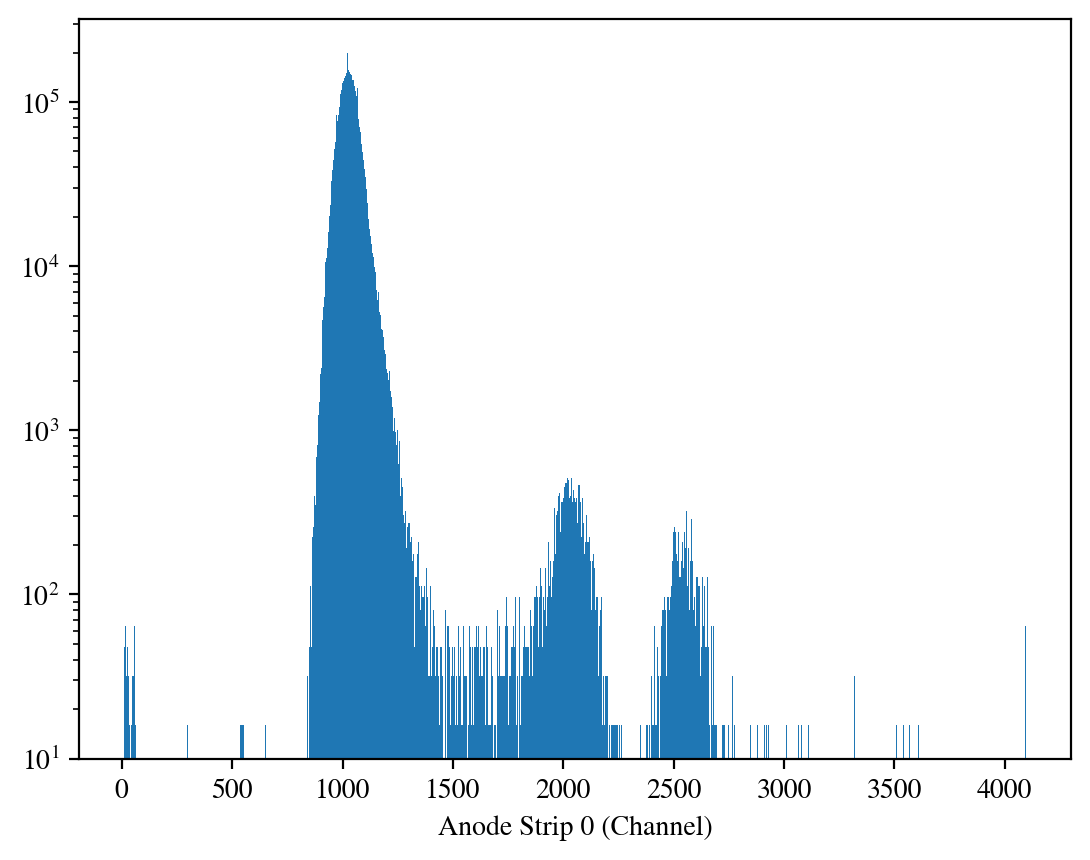

In [18]:
plt.hist(branches['strip0'],
            bins=1000)
plt.xlabel('Anode Strip 0 (Channel)')
plt.yscale('log')

plt.show()

It is also easy to make a 2D histogram. Here, we can even give it the "COLZ" look from ROOT using a norm function.

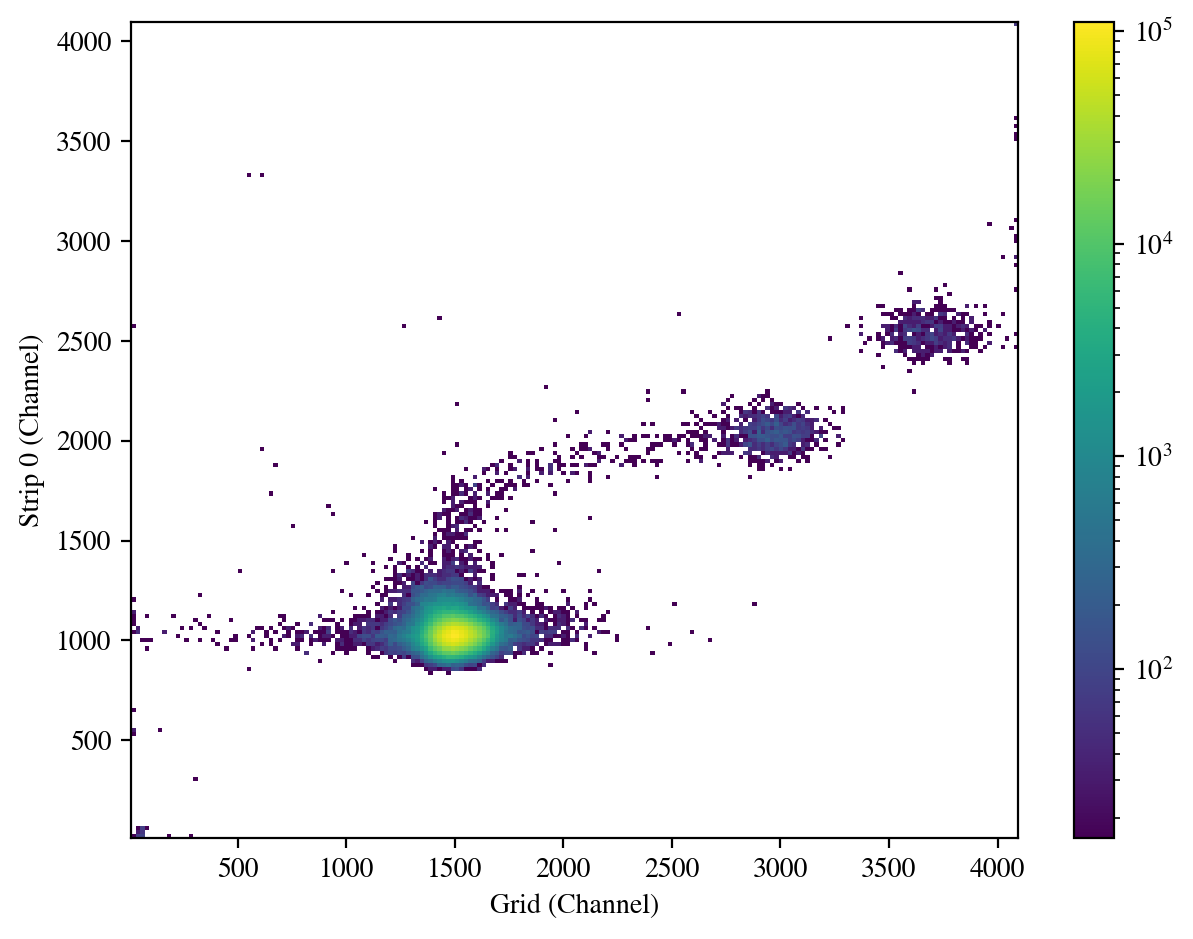

In [21]:
from matplotlib.colors import LogNorm

plt.hist2d(branches['grid'], branches['strip0'],
           bins=200,
           norm=LogNorm())
plt.xlabel('Grid (Channel)')
plt.ylabel('Strip 0 (Channel)')

plt.colorbar()
plt.tight_layout()
plt.show()